In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
F1 = 32
D = 2
F2 = 64  # F2 = F1 * D
hidden_dim_lstm = 64
batch_size = 256
epochs = 200
learning_rate = 0.0001
patience = 8

In [9]:
class EEGNet(nn.Module):
    def __init__(self, Elec_num, T, F1 = 4, D = 2, F2 = 8, hidden_dim_lstm=32):
        super(EEGNet, self).__init__()
        self.drop_out = 0.3
 
        self.block_1 = nn.Sequential(
            # Pads the input tensor boundaries with zero
            # left, right, up, bottom
            nn.ZeroPad2d((32, 32, 0, 0)),
            nn.Conv2d(
                in_channels=1,  # input shape (1, C, T)
                out_channels=F1,  # num_filters
                kernel_size=(1, 64),  # X 16 X_origin 128
                bias=False
            ),  # output shape (F1, C, T)
            nn.BatchNorm2d(F1)  # output shape (F1, C, T)
        )
 
        # block 2 and 3 are implementations of Depthwise Convolution and Separable Convolution
        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=F1,  # input shape (F1, C, T)
                out_channels=F2,  # num_filters
                kernel_size=(Elec_num, 1),  # filter size
                # group8意味着八组滤波器
                groups=F1,
                bias=False
            ),  # output shape (F2, 1, T)
            nn.BatchNorm2d(F2),  # output shape (F2, 1, T)
            nn.ELU(),
            nn.AvgPool2d((1, 4)),  # output shape (F2, 1, T//4) X 2 X_origin 4
            nn.Dropout(self.drop_out)  # output shape (F2, 1, T//4)
        )
 
        self.block_3 = nn.Sequential(
            nn.ZeroPad2d((8, 8, 0, 0)),
            nn.Conv2d(
                in_channels=F2,  # input shape (F2, 1, T//4)
                out_channels=F2,  # num_filters
                kernel_size=(1, 16),  # filter size X 16 X_origin 64
                # 十六组滤波器
                groups=F2,
                bias=False
            ),  # output shape (F2, 1, T//4)
            nn.Conv2d(
                in_channels=F2,  # input shape (F2, 1, T//4)
                out_channels=F2,  # num_filters
                kernel_size=(1, 1),  # filter size
                bias=False
            ),  # output shape (F2, 1, T//4)
            nn.BatchNorm2d(F2),  # output shape (F2, 1, T//4)
            nn.ELU(),
            nn.AvgPool2d((1, 4)),  # output shape (F2, 1, T//32) # X 2 X_origin 8
            nn.Dropout(self.drop_out)
        )
        
        self.lstm = nn.LSTM(F2, hidden_dim_lstm, batch_first=True, bidirectional=True)
 
        self.out = nn.Linear((hidden_dim_lstm * 2 * (T//16)), 1) # X 4 X_origin 32
 
    def forward(self, x):
        x = self.block_1(x)
        # print("block1", x.shape)
        x = self.block_2(x)
        # print("block2", x.shape)
        x = self.block_3(x)
        # print("block3", x.shape)
        x = x.squeeze(2)
        
        # print("lstm_input", x.shape)

        x = x.transpose(1, 2) 
        x, _ = self.lstm(x)
 
        x = x.reshape(x.size(0), -1)
        x = self.out(x)
        # return F.softmax(x, dim=1), x  # return x for visualization
        x = x.squeeze(1)
        return x

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience  # The number of epochs to wait for improvement
        self.min_delta = min_delta  # Minimum change to qualify as an improvement
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset the counter
        else:
            self.counter += 1  # Increment the counter
            if self.counter >= self.patience:
                self.early_stop = True

In [10]:
X_train = np.load(f"X_train.npy")
X_val = np.load(f"X_val.npy")
X_test = np.load(f"X_test.npy")
y_train = np.load(f"y_train.npy")
y_val = np.load(f"y_val.npy")
y_test = np.load(f"y_test.npy")

# 转为 tensor，并在第二个维度添加一个维度
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # (N, 1, C, T)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)

y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [11]:
model = EEGNet(8, 1000, F1, D, F2, hidden_dim_lstm).to(device)
params_num = sum(p.numel() for p in model.parameters())
print(f"Num of parameters: {params_num}")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
early_stopping = EarlyStopping(patience=patience)

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    num_batches = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        num_batches += 1
        
    if epoch%10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Training RMSE Loss: {np.sqrt(running_loss / num_batches):.6f}")

    # Validation loss
    model.eval()
    total_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for i in range(0, len(X_val), batch_size):
            batch_X = X_val[i:i+batch_size]
            batch_y = y_val[i:i+batch_size]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 确保数据在 GPU 上
            batch_outputs = model(batch_X)
            batch_loss = criterion(batch_outputs, batch_y)
            
            total_loss += batch_loss.item()
            num_batches += 1
    # 计算平均损失
    avg_loss = total_loss / num_batches
    if epoch%10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Validation RMSE Loss: {np.sqrt(avg_loss):.6f}")

    # Early stopping check
    early_stopping(avg_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

    # Save the model if the loss improved
    if avg_loss <= early_stopping.best_loss:
        torch.save(model.state_dict(), os.path.join(f'best_model.pth'))
        # print(f"Model saved for {pt}")

# Load the best model and evaluate on test set
# model.load_state_dict(torch.load(os.path.join(result_path, f'{pt}_best_model.pth')))
model.load_state_dict(torch.load(os.path.join(f'best_model.pth'), weights_only=True))
model.eval()
total_loss = 0.0
num_batches = 0
all_preds = []
with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch_X = X_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 确保数据在 GPU 上
        batch_outputs = model(batch_X)
        all_preds.append(batch_outputs.cpu().numpy())
        batch_loss = criterion(batch_outputs, batch_y)
        
        total_loss += batch_loss.item()
        num_batches += 1
# 计算平均损失
avg_loss = total_loss / num_batches
print(f"Test RMSE Loss : {np.sqrt(avg_loss):.6f}")
all_preds = np.concatenate(all_preds, axis=0)
np.save(os.path.join(f'pred.npy'), all_preds)

torch.cuda.empty_cache()

Num of parameters: 82497
Epoch [1/200], Training RMSE Loss: 3.813827
Epoch [1/200], Validation RMSE Loss: 3.709613
Epoch [11/200], Training RMSE Loss: 3.692268
Epoch [11/200], Validation RMSE Loss: 3.662845
Epoch [21/200], Training RMSE Loss: 3.584917
Epoch [21/200], Validation RMSE Loss: 3.463847
Epoch [31/200], Training RMSE Loss: 3.497323
Epoch [31/200], Validation RMSE Loss: 3.425462
Early stopping triggered
Test RMSE Loss : 3.461192


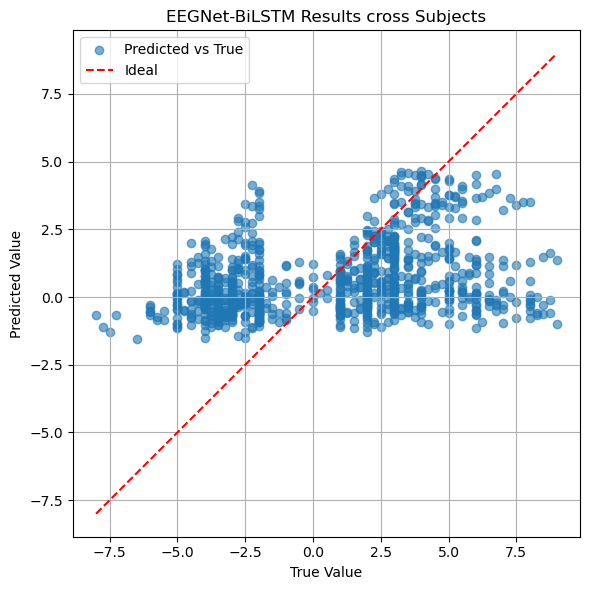

Test MSE: 11.979852
Pearson correlation: 0.3421


In [13]:
y_pred = all_preds.reshape(-1)
y_test = np.load(f"y_test.npy")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs True')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("True Value")
plt.ylabel("Predicted Value")
plt.title("EEGNet-BiLSTM Results cross Subjects")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"Test MSE: {avg_loss:.6f}")
corr, _ = pearsonr(y_test, y_pred)
print(f"Pearson correlation: {float(corr):.4f}")